## Install

In [1]:
# install
!pip install federpy

# import
from federpy.federpy import FederPy

### Data Preparation

In [2]:
# index file built by hnswlib or faiss.
hnswSource = 'hnswlib'
hnswIndexFile = 'https://assets.zilliz.com/hnswlib_hnsw_voc_17k_1f1dfd63a9.index'

ivfflatSource = 'faiss'
ivfflatIndexFile = 'https://assets.zilliz.com/faiss_ivf_flat_voc_17k_ab112eec72.index'

In [3]:
import pandas as pd

# this csv includes 17,000+ items，each only includes its filename.
namesFile = "https://assets.zilliz.com/voc_names_4cee9440b1.csv"

namesCsv = pd.read_csv(namesFile)
imageUrls = ["https://assets.zilliz.com/voc2012/JPEGImages/%s" % row['name'] for index, row in namesCsv.iterrows()]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Vis for IVF_Flat (faiss)

In [4]:
ivfflatViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls,
    "projectMethod": "umap",
}
federPy_ivfflat = FederPy(ivfflatIndexFile, ivfflatSource, **ivfflatViewParams)

### Overview

In [5]:
federPy_ivfflat.overview()

### Search View

In [6]:
federPy_ivfflat.setSearchParams({"k": 9, "nprobe": 8}).searchRandTestVec()

## Vis for HNSW (hnswlib)

In [7]:
# init federpy
hnswViewParams = {
    "width": 800,
    "height": 500,
    "mediaType": "image",
    "mediaUrls": imageUrls
}
federPy_hnsw = FederPy(hnswIndexFile, hnswSource, **hnswViewParams)

### Overview

In [8]:
federPy_hnsw.overview()

### Search View

In [9]:
federPy_hnsw.setSearchParams({"k": 6, "ef": 8}).searchRandTestVec()

## Code

### IVF, HNSW class

In [10]:

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


class IVF:

    def _compute_distance(self, data, q):
        """Compute the appropriate distance based on the distance type."""
        if self.distance_type == 'l2':
            return np.linalg.norm(data - q, axis=1)
        elif self.distance_type == 'cosine':
            return 1 - np.dot(data, q.T) / (np.linalg.norm(data, axis=1) * np.linalg.norm(q))


    def __init__(self, distance_type, n_clusters):

        self.n_clusters = n_clusters
        self.distance_type = distance_type
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.inverted_index = {i: [] for i in range(n_clusters)}
        self.data = None
        self.visited_count = 0


    def fit(self, X):

        if self.distance_type == 'cosine':
            X = X / np.linalg.norm(X, axis=1, keepdims=True)

        self.kmeans.fit(X)
        labels = self.kmeans.labels_

        for idx, label in enumerate(labels):
            self.inverted_index[label].append(idx)

        self.data = X



    def search(self, q, k, n_probes=1):

        self.visited_count = 0

        assert n_probes <= self.n_clusters

        if self.distance_type == "cosine":
            q = q / np.linalg.norm(q)

        cluster_distances = self._compute_distance(self.kmeans.cluster_centers_, q).flatten()
        probe_clusters = np.argpartition(cluster_distances, n_probes)[:n_probes]

        candidates = np.concatenate([self.inverted_index[cl] for cl in probe_clusters])

        self.visited_count += len(candidates)

        if len(candidates) <= k:
            return candidates

        dists = self._compute_distance(self.data[candidates], q).flatten()
        top_idx = np.argpartition(dists, k)[:k]

        top_k = candidates[top_idx]
        top_dist = dists[top_idx]

        return [(k, dist) for k, dist in zip(top_k, top_dist)]



In [11]:
# https://github.com/RyanLiGod/hnsw-python/blob/master/hnsw.py

from heapq import heapify, heappop, heappush, heapreplace, nlargest
from math import log2
from operator import itemgetter
from random import random
import numpy as np

class HNSW:
    # self._graphs[level][i] contains a {j: dist} dictionary,
    # where j is a neighbor of i and dist is distance

    def l2_distance(self, a, b):
        return np.linalg.norm(a - b)

    def cosine_distance(self, a, b):
        try:
            return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        except ValueError:
            print(a)
            print(b)

    def vectorized_distance_(self, x, ys):
        return [self.distance_func(x, y) for y in ys]

    def __init__(self, distance_type, M=5, efConstruction=200, Mmax=None):
        if distance_type == "l2":
            distance_func = self.l2_distance
        elif distance_type == "cosine":
            distance_func = self.cosine_distance
        else:
            raise TypeError('Please check your distance type!')
        self.distance_func = distance_func
        self.vectorized_distance = self.vectorized_distance_
        self._M = M
        self._efConstruction = efConstruction
        self._Mmax = 2 * M if Mmax is None else Mmax
        self._level_mult = 1 / log2(M)
        self._graphs = []
        self._enter_point = None
        self.data = []
        self.visited_count = 0

    ### Algorithm 1: INSERT
    def insert(self, q, efConstruction=None):

        if efConstruction is None:
            efConstruction = self._efConstruction

        distance = self.distance_func
        data = self.data
        graphs = self._graphs
        ep = self._enter_point
        M = self._M

        # line 4: determine level for the new element q
        l = int(-log2(random()) * self._level_mult) + 1
        idx = len(data)
        data.append(q)

        if ep is not None:
            neg_dist = -distance(q, data[ep])
            # distance(q, data[ep])|

            # line 5-7: find the closest neighbor for levels above the insertion level
            for lc in reversed(graphs[l:]):
                neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

            # line 8-17: insert q at the relevant levels; W is a candidate list
            layer0 = graphs[0]
            for lc in reversed(graphs[:l]):
                M_layer = M if lc is not layer0 else self._Mmax

                # line 9: update W with the closest nodes found in the graph
                W = self._search_layer(q, [(neg_dist, ep)], lc, efConstruction)

                # line 10: insert the best neighbors for q at this layer
                lc[idx] = layer_idx = {}
                self._select(layer_idx, W, M_layer, lc, heap=True)

                # line 11-13: insert bidirectional links to the new node
                for j, dist in layer_idx.items():
                    self._select(lc[j], (idx, dist), M_layer, lc)

        # line 18: create empty graphs for all new levels
        for _ in range(len(graphs), l):
            graphs.append({idx: {}})
            self._enter_point = idx


    ### Algorithm 5: K-NN-SEARCH
    def search(self, q, K=5, efSearch=20):
        """Find the K points closest to q."""

        distance = self.distance_func
        graphs = self._graphs
        ep = self._enter_point
        self.visited_count = 0

        if ep is None:
            raise ValueError("Empty graph")

        neg_dist = -distance(q, self.data[ep])

        # line 1-5: search from top layers down to the second level
        for lc in reversed(graphs[1:]):
            neg_dist, ep = self._search_layer(q, [(neg_dist, ep)], lc, 1)[0]

        # line 6: search with efSearch neighbors at the bottom level
        W = self._search_layer(q, [(neg_dist, ep)], graphs[0], efSearch)

        if K is not None:
            W = nlargest(K, W)
        else:
            W.sort(reverse=True)

        return [(idx, -md) for md, idx in W]


    ### Algorithm 2: SEARCH-LAYER
    def _search_layer(self, q, W, lc, ef):

        vectorized_distance = self.vectorized_distance
        data = self.data

        # Step 1: Initialize candidate list and visited set
        C = [(-neg_dist, idx) for neg_dist, idx in W]
        heapify(C)
        heapify(W)
        visited = set(idx for _, idx in W)

        # Step 4-17: Explore neighbors until candidate list is exhausted
        while C:
            dist, c = heappop(C)
            furthest = -W[0][0]
            if dist > furthest:
                break
            neighbors = [e for e in lc[c] if e not in visited]
            visited.update(neighbors)
            dists = vectorized_distance(q, [data[e] for e in neighbors])
            for e, dist in zip(neighbors, dists):
                self.visited_count += 1
                neg_dist = -dist
                if len(W) < ef:
                    heappush(C, (dist, e))
                    heappush(W, (neg_dist, e))
                    furthest = -W[0][0]
                elif dist < furthest:
                    heappush(C, (dist, e))
                    heapreplace(W, (neg_dist, e))
                    furthest = -W[0][0]

        return W

    ### Algorithm 3: SELECT-NEIGHBORS-SIMPLE
    def _select(self, R, C, M, lc, heap=False):

        if not heap:
            idx, dist = C
            if len(R) < M:
                R[idx] = dist
            else:
                max_idx, max_dist = max(R.items(), key=itemgetter(1))
                if dist < max_dist:
                    del R[max_idx]
                    R[idx] = dist
            return

        else:
            C = nlargest(M, C)
            R.update({idx: -neg_dist for neg_dist, idx in C})


### Data Preparation

In [12]:
import pandas as pd

data_raw = pd.read_parquet('openai_embedding_raw.parquet')
data_raw.head()

_id                    title  \
84780  <dbpedia:Johann_Evangelist_Haydn>  Johann Evangelist Haydn   
66903     <dbpedia:Powhatan_Point,_Ohio>     Powhatan Point, Ohio   
8436    <dbpedia:Demographics_of_Malawi>   Demographics of Malawi   
44449                <dbpedia:Drag_king>                Drag king   
89273               <dbpedia:Graubünden>               Graubünden   

                                                    text  \
84780  Johann Evangelist Haydn (December 23, 1743 – M...   
66903  Powhatan Point is a village in Belmont County,...   
8436   This article is about the demographic features...   
44449  Drag kings are mostly female performance artis...   
89273  The Canton of Grisons or Graubünden in German ...   

                                                  openai  
84780  [-0.032199163, -0.015079984, 0.0022830819, -0....  
66903  [0.0017795308, -0.009837335, 0.017735092, 0.00...  
8436   [0.00032719361, 0.0035149942, 0.006899111, -0....  
44449  [-0.033335887, -0.02453067, -0.012788225, -0.0...  
89273  [0.008936312, 0.006216003, 0.0330314, -0.02850...

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import time

f = h5py.File('openai_embedding_output.hdf5','r')
distances = f['distances']
neighbors = f['neighbors']
test = f['test']
train = f['train']

In [14]:
distances

<HDF5 dataset "distances": shape (100, 100), type "<f8">

In [15]:
distances[0]

array([0.18023628, 0.18199849, 0.19761407, 0.20239192, 0.20566928,
       0.20731825, 0.20835632, 0.21049082, 0.21167642, 0.21186999,
       0.21456342, 0.2189573 , 0.21966851, 0.21986413, 0.2200197 ,
       0.22160095, 0.22203791, 0.22396915, 0.2240731 , 0.22436839,
       0.22584665, 0.2262705 , 0.22759867, 0.22831796, 0.22870576,
       0.22969215, 0.22984701, 0.23261583, 0.23263752, 0.23380172,
       0.23627774, 0.23633747, 0.23942387, 0.24004488, 0.24009627,
       0.24016446, 0.24083047, 0.24104905, 0.24112015, 0.24132645,
       0.24161463, 0.24238586, 0.24336779, 0.24444872, 0.24447459,
       0.24466473, 0.2450949 , 0.24516639, 0.24562347, 0.24564163,
       0.24572139, 0.24576478, 0.24611089, 0.24627946, 0.24634199,
       0.24644673, 0.24647534, 0.24690586, 0.24730973, 0.24737041,
       0.24895797, 0.24954307, 0.25012164, 0.25015455, 0.2510882 ,
       0.25342256, 0.25350779, 0.25392652, 0.25498772, 0.25530408,
       0.25627756, 0.25639355, 0.25669132, 0.25681838, 0.25688

In [16]:
neighbors

<HDF5 dataset "neighbors": shape (100, 100), type "<i8">

In [17]:
neighbors[0]

array([791, 199, 270, 498, 320, 628, 520, 739, 358,  35, 350, 387, 593,
       230,  52, 344, 644, 632,  78, 152, 678, 765, 780, 480, 831, 192,
       138, 519, 624,  49,  39,  19, 665, 315, 800, 813, 647, 575,  55,
       293, 186, 210, 627,  23, 865, 599, 158, 275, 573, 122, 860, 156,
       336,  30, 165, 425, 653, 402, 155, 706, 540, 509, 810, 348, 595,
       413, 640, 259, 184, 460, 442,  33, 533, 818, 252, 448, 176, 618,
       685, 125, 114, 169, 796, 313, 209, 341, 455, 175, 412, 222, 890,
       829, 118, 144, 376,  17,   1, 617, 424, 206])

In [18]:
train

<HDF5 dataset "train": shape (900, 1536), type "<f4">

In [19]:
test

<HDF5 dataset "test": shape (100, 1536), type "<f4">

### IVF code

In [20]:
ivf = IVF("cosine", n_clusters = 100)

ivf.fit(train)

/Users/jyp/opt/anaconda3/envs/rl_metro/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [21]:
## cluster 확인
# ivf.inverted_index

In [22]:
## cluster별 데이터 수
for i in range(10):
    print(f"cluster {i} : {len(ivf.inverted_index[i])}")

cluster 0 : 3
cluster 1 : 8
cluster 2 : 12
cluster 3 : 29
cluster 4 : 17
cluster 5 : 12
cluster 6 : 8
cluster 7 : 5
cluster 8 : 16
cluster 9 : 16


In [23]:
## centroid 확인
ivf.kmeans.cluster_centers_

array([[ 0.00408399, -0.00942386, -0.0095148 , ..., -0.02019785,
        -0.00527798, -0.01153486],
       [ 0.00812824,  0.00044305,  0.00241017, ..., -0.00278608,
        -0.01434772, -0.02066743],
       [-0.00680353, -0.01012305,  0.00010446, ..., -0.01265378,
         0.00656154, -0.00828458],
       ...,
       [-0.01012742, -0.01204752, -0.00261168, ..., -0.0078939 ,
        -0.00077195, -0.00283386],
       [ 0.00214548, -0.0045014 ,  0.01486588, ..., -0.00884276,
        -0.00132906, -0.02145363],
       [-0.00117672, -0.01173989, -0.00078398, ..., -0.01052708,
        -0.02180719, -0.0130015 ]], dtype=float32)

In [24]:
## search
ivf.search(test[0], k = 5, n_probes = 3)

[(199, 0.18199843),
 (791, 0.18023598),
 (270, 0.19761372),
 (498, 0.20239222),
 (320, 0.20566946)]

In [25]:
## 방문한 벡터 수
ivf.visited_count

36

In [26]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

### IVF 성능평가

In [27]:
## index build time
n_clusters = [50, 100, 150]
times = []
for n_cluster in n_clusters:
    ivf = IVF("cosine", n_clusters = n_cluster)
    start = time.time()
    ivf.fit(train)
    times.append(time.time() - start)

for n_cluster, time_ in zip(n_clusters, times):
    print(f"n_cluster : {n_cluster}, build time : {time_}")


n_cluster : 50, build time : 0.3094019889831543
n_cluster : 100, build time : 0.3097538948059082
n_cluster : 150, build time : 0.5026419162750244


In [28]:
## n_cluster = sqrt(len(data))를 권장

ivf = IVF("cosine", n_clusters = 100)
ivf.fit(train)

In [29]:
## search speed and accuracy with different n_probe
n_probes = [3, 7, 10, 15]
qps_ivf = []
accuracies_ivf = []
visited_ivf = []

for n_probe in n_probes:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = ivf.search(test[i], 5, n_probe)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(ivf.visited_count)

    accuracies_ivf.append(np.mean(query_acc))
    qps_ivf.append(1 / np.mean(query_per_second))
    visited_ivf.append(np.mean(query_visit))

for n_probe, acc, qp, v in zip(n_probes, accuracies_ivf, qps_ivf, visited_ivf):
    print(f"n_probe : {n_probe}, accuracy : {acc}, qps : {qp}, visited : {v}")

n_probe : 3, accuracy : 0.7339999999999999, qps : 3757.6971662530573, visited : 37.18
n_probe : 7, accuracy : 0.86, qps : 3227.7284410447414, visited : 83.47
n_probe : 10, accuracy : 0.9079999999999999, qps : 2966.1848321122457, visited : 118.39
n_probe : 15, accuracy : 0.9420000000000002, qps : 2365.7070661492644, visited : 172.62


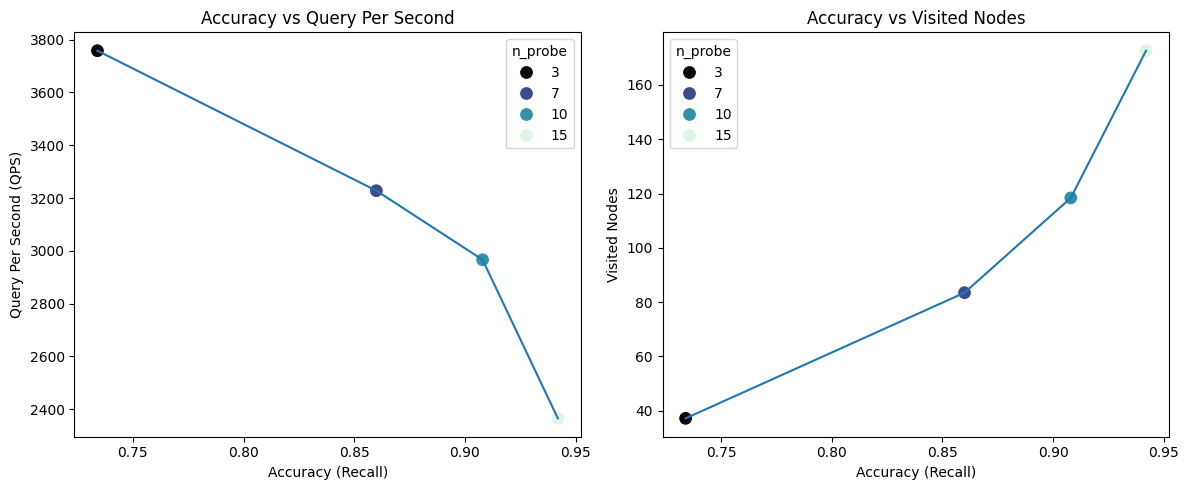

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_ivf, y=qps_ivf)
sns.scatterplot(x=accuracies_ivf, y=qps_ivf, hue=n_probes, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")
plt.title("Accuracy vs Query Per Second")

plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_ivf, y=visited_ivf)
sns.scatterplot(x=accuracies_ivf, y=visited_ivf, hue=n_probes, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()

### HNSW code

In [31]:
hnsw = HNSW("cosine", M = 16, efConstruction=64)

for i in range(len(train)):
    hnsw.insert(train[i])

In [32]:
## hnsw index 확인
# hnsw._graphs

In [33]:
## layer별 노드 수
for i in range(len(hnsw._graphs)):
    print(f"layer {i} : {len(hnsw._graphs[i])}")

layer 0 : 900
layer 1 : 59
layer 2 : 2


In [34]:
## search

hnsw.search(test[0], 5)

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239180326461792),
 (320, 0.20566928386688232)]

In [35]:
## true-NN 확인
[(n, d) for d, n in zip(distances[0][:5], neighbors[0][:5])]

[(791, 0.18023627996444702),
 (199, 0.18199849128723145),
 (270, 0.19761407375335693),
 (498, 0.20239192247390747),
 (320, 0.20566928386688232)]

In [36]:
## 평균 방문 노드 수 확인
visit = []
for i in range(len(test)):
    hnsw.search(test[i], 5, 20)
    visit.append(hnsw.visited_count)

print(np.mean(visit))

260.87


In [37]:
visit_k = []

for ef in [20, 50, 100]:
    visit = []
    for i in range(len(test)):
        hnsw.search(test[i], 5, ef)
        visit.append(hnsw.visited_count)

    visit_k.append(np.mean(visit))

visit_k

[260.87, 400.0, 517.49]

### HNSW 성능평가

In [38]:
build_time_df = pd.DataFrame(columns=["M", "efConstruction", "build time"])

# Parameters
M = [5, 10, 15]
efConstruction = [32, 48, 64]

for m in M:
    for ef in efConstruction:
        hnsw = HNSW("cosine", M=m, efConstruction=ef)
        start = time.time()
        for i in range(len(train)):
            hnsw.insert(train[i])
        build_time = time.time() - start

        # Use pd.concat to add a row
        build_time_df = pd.concat(
            [build_time_df, pd.DataFrame({"M": [m], "efConstruction": [ef], "build time": [build_time]})],
            ignore_index=True
        )

/var/folders/tg/kzvsy50j0gzcw020vt7p2jzc0000gn/T/ipykernel_23696/3152774322.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  build_time_df = pd.concat(


In [39]:
build_time_df

M efConstruction  build time
0   5             32    0.883685
1   5             48    1.611705
2   5             64    1.622023
3  10             32    1.458824
4  10             48    1.742223
5  10             64    2.012906
6  15             32    1.943898
7  15             48    1.932155
8  15             64    2.211669

<Axes: xlabel='M', ylabel='build time'>

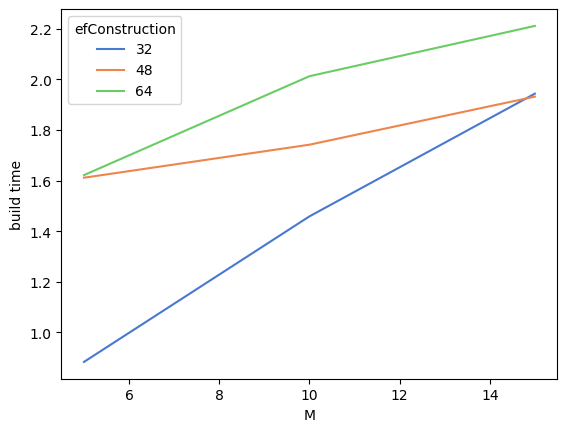

In [40]:
sns.lineplot(x = 'M', y = 'build time', data = build_time_df, hue = 'efConstruction', palette = "muted")

In [41]:
efs = [10, 20, 30, 50, 100]
accuracies_hnsw = []
qps_hnsw = []
visited_hnsw = []

for ef in efs:

    query_acc = []
    query_per_second = []
    query_visit = []

    for i in range(len(test)):
        start = time.time()
        search_result = hnsw.search(test[i], 5, ef)
        query_per_second.append(time.time() - start)

        acc = len(set(neighbors[i][:5]) & set([idx for idx, _ in search_result])) / 5
        query_acc.append(acc)

        query_visit.append(hnsw.visited_count)

    qps_hnsw.append(1 / np.mean(query_per_second))
    accuracies_hnsw.append(np.mean(query_acc))
    visited_hnsw.append(np.mean(query_visit))


for ef, acc, qp, v in zip(efs, accuracies_hnsw, qps_hnsw, visited_hnsw):
    print(f"ef : {ef}, accuracy : {acc}, qps : {qp}, visited : {v}")


ef : 10, accuracy : 0.9580000000000001, qps : 458.2226096912411, visited : 180.13
ef : 20, accuracy : 0.9840000000000001, qps : 473.65060579745165, visited : 250.74
ef : 30, accuracy : 0.992, qps : 399.05087196856533, visited : 304.51
ef : 50, accuracy : 0.998, qps : 309.2458090055231, visited : 387.94
ef : 100, accuracy : 0.998, qps : 209.65796337599835, visited : 506.11


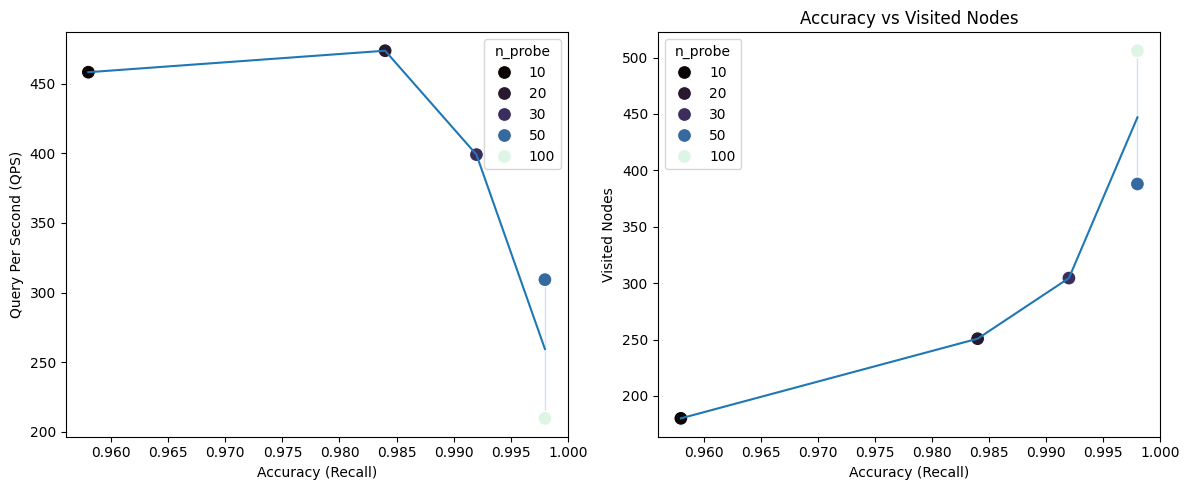

In [42]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_hnsw, y=qps_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=qps_hnsw, hue=efs, s=100, legend="full", palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend(title="n_probe")


plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_hnsw, y=visited_hnsw)
sns.scatterplot(x=accuracies_hnsw, y=visited_hnsw, hue=efs, s=100, palette = "mako")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Visited Nodes")
plt.legend(title="n_probe")
plt.title("Accuracy vs Visited Nodes")

plt.tight_layout()
plt.show()

### IVF vs HNSW

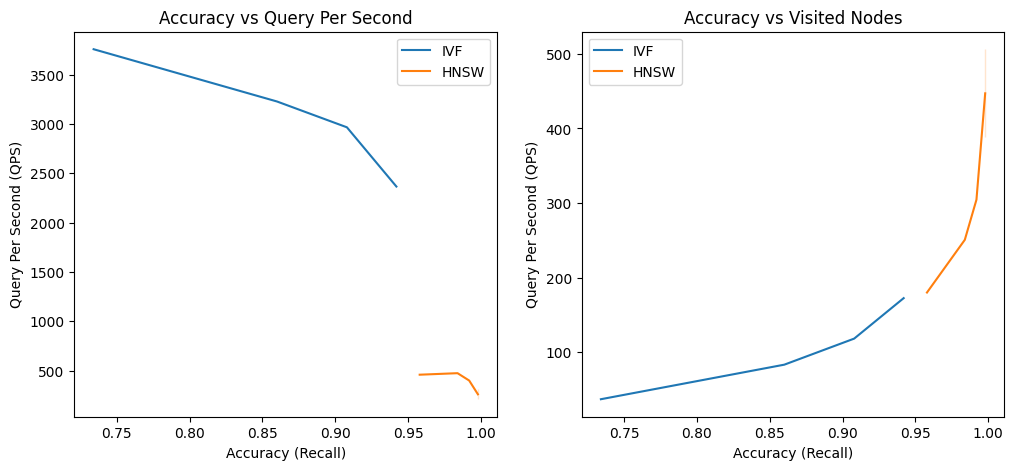

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=accuracies_ivf, y=qps_ivf, label = "IVF")
sns.lineplot(x=accuracies_hnsw, y=qps_hnsw, label = "HNSW")
plt.title("Accuracy vs Query Per Second")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x=accuracies_ivf, y=visited_ivf, label = "IVF")
sns.lineplot(x=accuracies_hnsw, y=visited_hnsw, label = "HNSW")
plt.title("Accuracy vs Visited Nodes")
plt.xlabel("Accuracy (Recall)")
plt.ylabel("Query Per Second (QPS)")
plt.legend()

plt.show()